In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [8]:
# reflect an existing database into a new model
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)
# reflect the tables

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
inspector = inspect(engine)

In [13]:
inspector.get_table_names()

['measurement', 'station']

In [14]:
# Using the inspector to print the column names within the 'measurement' and 'station' tables and its types
measure_columns = inspector.get_columns('measurement')
print("Measurement")
for column in measure_columns:
    print(column["name"], column["type"])
    
print("--")

station_columns = inspector.get_columns('station')
print("Station")
for column in station_columns:
    print(column["name"], column["type"])


Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--
Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
print(f"The latest date is: {latest_date[0]}")

# 2017 is a common year
# date 1 year ago from 2017-08-23
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"Date 1 year ago: {year_ago}")


The latest date is: 2017-08-23
Date 1 year ago: 2016-08-23


In [16]:
# Perform a query to retrieve the date and precipitation scores
scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).all()
scores[:10]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0)]

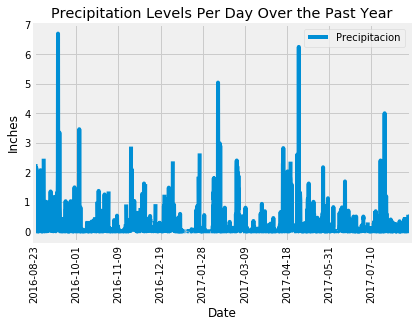

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
scores_df = pd.DataFrame(scores, columns = ["Date","Precipitacion"])
scores_df.set_index("Date", inplace= True)

# Sort the dataframe by date
scores_sorted = scores_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data

# Use Pandas Plotting with Matplotlib to plot the data
scores_sorted.plot(rot=90)
plt.title("Precipitation Levels Per Day Over the Past Year")
plt.ylabel("Inches")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
scores_sorted.describe()

,Precipitacion
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()
station_count

[(9)]

In [20]:
pd.read_sql("select * from measurement limit 5", engine)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.min(Measurement.tobs),
            func.max(Measurement.tobs),
            func.avg(Measurement.tobs)).\
            filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_station = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date >= year_ago).all()
highest_station[:10]

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0)]

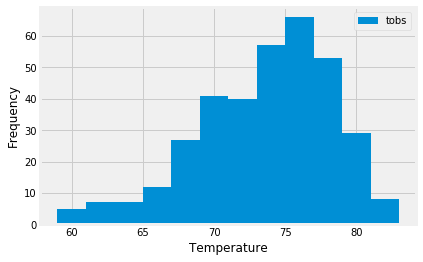

In [24]:
# Plot the results as a histogram with bins=12
# Save it like a DataFrame
highest_df = pd.DataFrame(highest_station)


highest_df.plot(kind="hist",bins=12)
plt.xlabel("Temperature")
plt.show()

In [25]:
pd.read_sql("select * from station limit 5", engine)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [26]:
pd.read_sql("select * from measurement limit 5", engine)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


## Bonus Challenge Assignment

### Temperature Analysis I

- Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

- You may either use SQLAlchemy or pandas's read_csv() to perform this portion.

- Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

- Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [27]:
# Average temperature in june

june_str = "06"

june = session.query(func.avg(Measurement.tobs)).\
    group_by(Measurement.station).\
    filter(func.strftime("%m", Measurement.date) == june_str).all()
june



[(74.13939393939394),
 (74.05084745762711),
 (76.00537634408602),
 (71.9372197309417),
 (76.6554054054054),
 (73.39473684210526),
 (73.27118644067797),
 (77.55932203389831),
 (76.66810344827586)]

In [28]:
# Average temperature in december

dec_str = "12"

december = session.query(func.avg(Measurement.tobs)).\
    group_by(Measurement.station).\
    filter(func.strftime("%m", Measurement.date) == dec_str).all()
december


[(69.6842105263158),
 (71.06944444444444),
 (73.2247191011236),
 (69.29126213592232),
 (71.8348623853211),
 (72.42105263157895),
 (69.90322580645162),
 (71.10952380952381),
 (72.43333333333334)]

In [29]:
import scipy.stats as stats

# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# I'll use an unpaired or independet t-test because it is a statistical procedure that compares the averages/means 
#of two independent or unrelated groups to determine if there is a significant difference between the two.
stats.ttest_ind(june, december, equal_var=False)

Ttest_indResult(statistic=array([4.61586542]), pvalue=array([0.00036573]))

### Temperature Analysis II

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Trip dates are 1/09/2016-13/09/2016

start_date = '2016-09-01'
end_date = '2016-09-13'

# function usage example
trip_temps = (calc_temps('2015-09-01', '2015-09-13'))
trip_temps

[(73.0, 78.6829268292683, 85.0)]

In [32]:
# Convert to DataFrame
temps_df = pd.DataFrame(trip_temps, columns=["Min Temp","Avg Temp","Max Temp"])
temps_df

,Min Temp,Avg Temp,Max Temp
0,73.0,78.682927,85.0


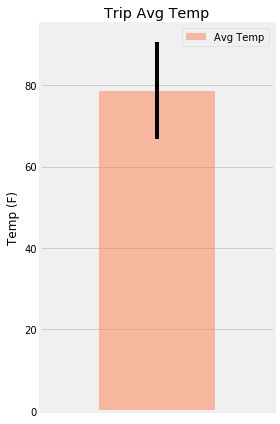

In [34]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temps_df.plot.bar(y="Avg Temp", yerr=(temps_df["Max Temp"] - temps_df["Min Temp"]), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1))

# Use the average temperature for the y value
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.show()

### Daily Rainfall Average

In [55]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# start and end date of the previos year which is 2015
start_date_prev = '2015-09-01'
end_date_prev = '2015-09-13'

rainfall = session.query(Station.station,  Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= start_date_prev).\
    filter(Measurement.date <= end_date_prev).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_df = pd.DataFrame(rainfall, columns=["Station","Name","Latitude","Longitude","Elevation","Prcp Sum"])
rainfall_df


,Station,Name,Latitude,Longitude,Elevation,Prcp Sum
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,7.51
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,6.06
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,5.71
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,5.44
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.28
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.05
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.90
7,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.36


In [54]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Trip dates are 1/09/2016-13/09/2016
start_date = '2016-09-01'
end_date = '2016-09-13'

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
